# Human Activity Recognition

Based on the [human-activity-recognition-with-smartphones](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones) dataset from Kaggle

## Data exploration and formatting

### Import Dependencies & Load Data

In [12]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor  # gradient boosted trees
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


# We'll need this later... get it out the way now
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

### Visualize Class Representations

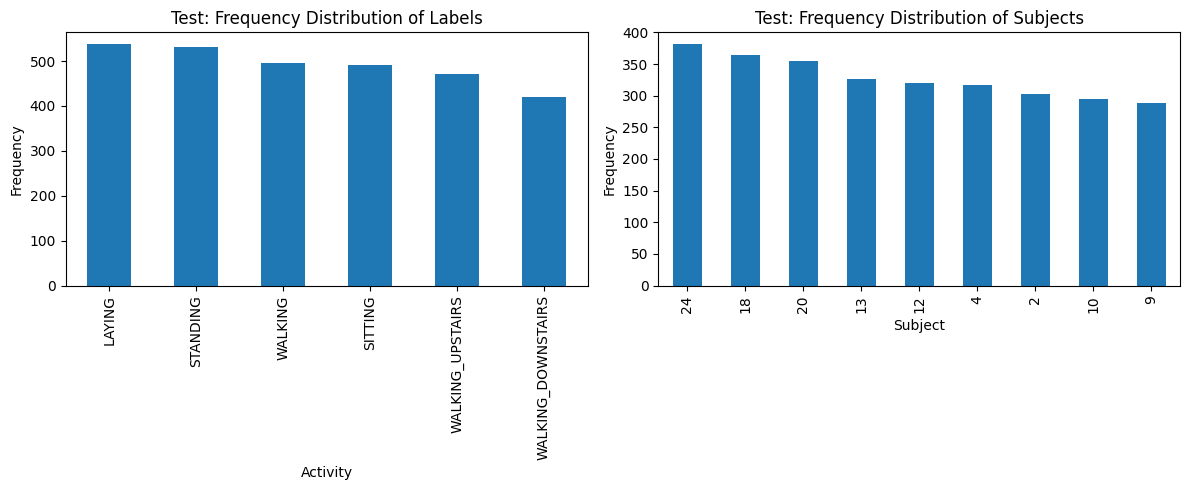

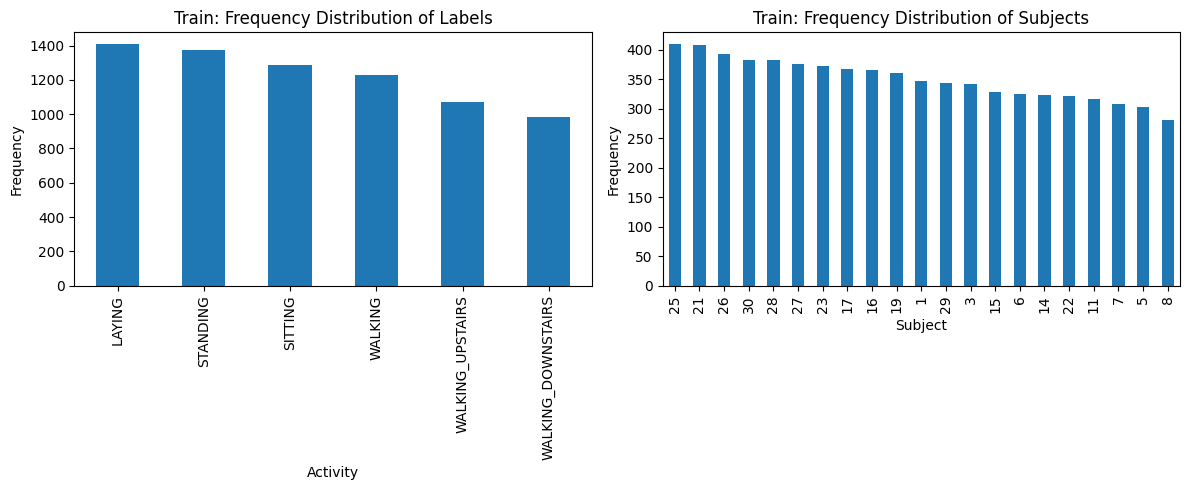

In [19]:
def organize_data(df):
    labels = df.Activity
    subjects = df.subject
    data = df.drop(['Activity', 'subject'], axis=1)
    return data, labels, subjects

def recode_labels(labels):
    label_encoder = LabelEncoder()
    labels_int = label_encoder.fit_transform(labels)
    label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
    return labels_int, label_mapping

def hot_encode_labels(labels):
    label_mapping = {label: index for index, label in enumerate(labels.unique())}
    return pd.get_dummies(labels), label_mapping

def plot_frequency_distributions(labels, subjects, subset):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    labels.value_counts().plot(kind='bar')
    plt.title(f'{subset}: Frequency Distribution of Labels')
    plt.xlabel('Activity')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    subjects.value_counts().plot(kind='bar')
    plt.title(f'{subset}: Frequency Distribution of Subjects')
    plt.xlabel('Subject')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


def anon():
    _, test_labels, test_subjects = organize_data(test_df)
    _, train_labels, train_subjects = organize_data(train_df)
    plot_frequency_distributions(test_labels, test_subjects, 'Test')
    plot_frequency_distributions(train_labels, train_subjects, 'Train')
anon()

### Visualize Data

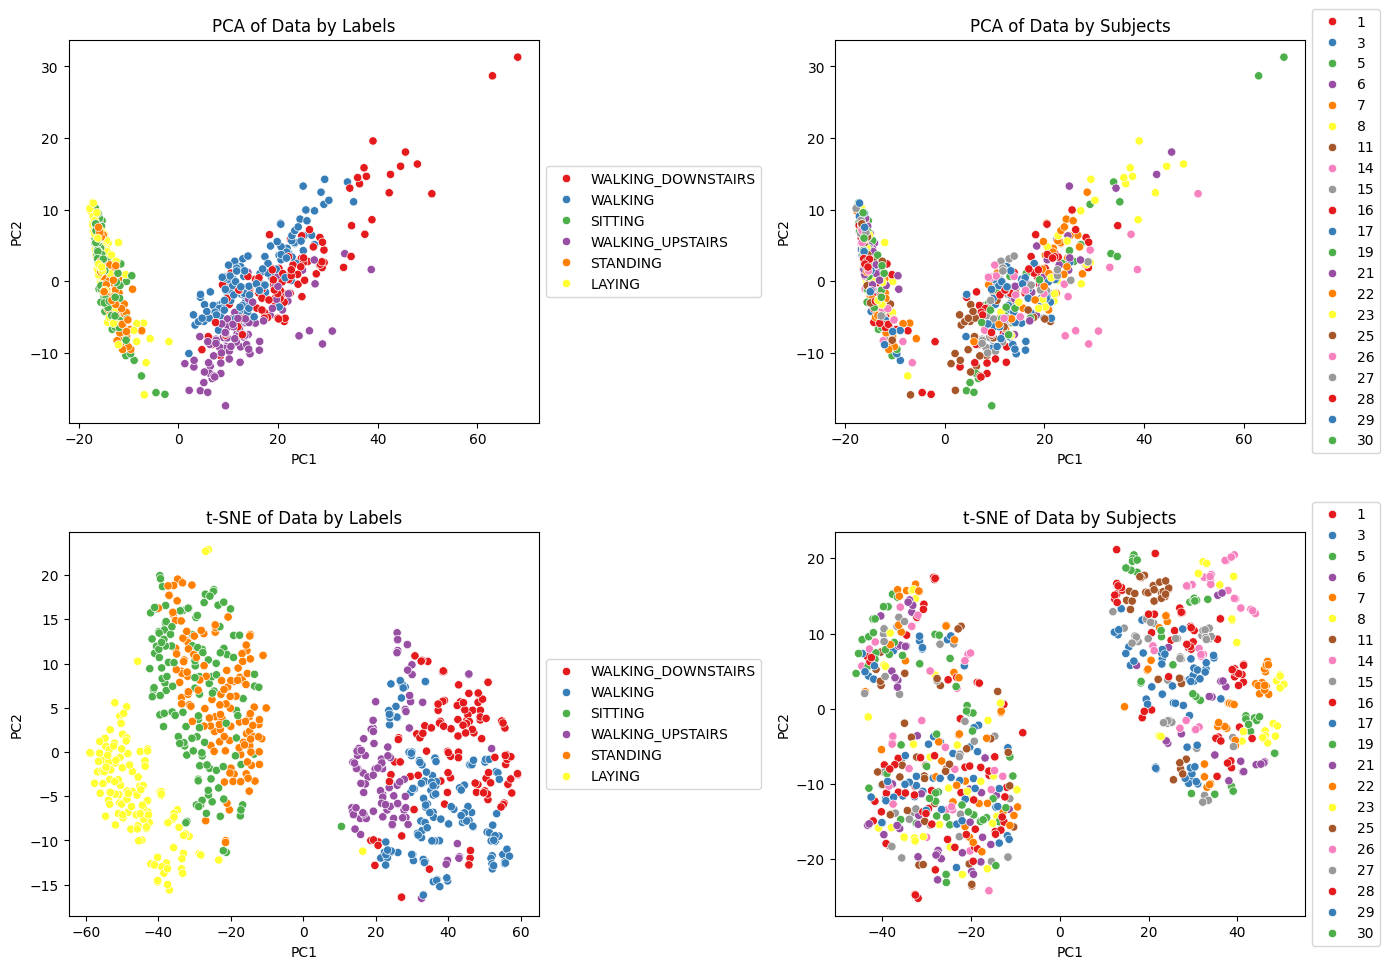

In [3]:
def anon():
    data, labels, subjects = organize_data(train_df)

    sample_fraction = 0.1 # Sample 10% of the data
    sampled_data = data.sample(frac=sample_fraction, random_state=42)
    sampled_labels = labels.loc[sampled_data.index]
    sampled_subjects = subjects.loc[sampled_data.index]

    def plot_pca(data, labels, ax, title):
        scl = StandardScaler()
        pca = PCA(n_components=2)
        scaled_data = scl.fit_transform(data)
        pca_result = pca.fit_transform(scaled_data)
        df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        df_pca['label'] = labels.values
        sns.scatterplot(x='PC1', y='PC2', hue='label', data=df_pca, palette='Set1', ax=ax)
        ax.set_title(title)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    def plot_tsne(data, labels, ax, title):
        scl = StandardScaler()
        tsne = TSNE(n_components=2)
        scaled_data = scl.fit_transform(data)
        tsne_result = tsne.fit_transform(scaled_data)
        df_tsne = pd.DataFrame(data=tsne_result, columns=['PC1', 'PC2'])
        df_tsne['label'] = labels.values
        sns.scatterplot(x='PC1', y='PC2', hue='label', data=df_tsne, palette='Set1', ax=ax)
        ax.set_title(title)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    plot_pca(sampled_data, sampled_labels, axes[0, 0], 'PCA of Data by Labels')
    plot_pca(sampled_data, sampled_subjects, axes[0, 1], 'PCA of Data by Subjects')
    plot_tsne(sampled_data, sampled_labels, axes[1, 0], 't-SNE of Data by Labels')
    plot_tsne(sampled_data, sampled_subjects, axes[1, 1], 't-SNE of Data by Subjects')

    plt.tight_layout()
    plt.show()

anon()

## Train a Model

Data looks pretty cleanly separable. Maybe An XGBoost can do it?

In [11]:
models = {}

def anon():
    params = {
        'n_estimators': 500,          # Rough number of trees to use.
        'early_stopping_rounds': 5,   # Rounds of no improvement before stopping.
        'learning_rate': 0.01,        # How much each tree should adjust the answer.
        'n_jobs': 4,                  # Parallel processing if available to the computer.
    }
    model = XGBClassifier(**params)
    models['XGB'] = {
        'model': model,
        'params': params,
    }

    data, labels, subjects = organize_data(train_df)
    label_encoder = LabelEncoder()
    labels_int = label_encoder.fit_transform(labels)
    label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

    X_train, X_test, y_train, y_test = train_test_split(data, labels_int, test_size=0.2, random_state=42)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
    )
anon()

In [18]:
def anon():
    model = models['XGB']['model']
    data, labels, subjects = organize_data(test_df)
    labels, mapping = recode_labels(labels)
    predictions = model.predict(data)
    accuracy = 100 * np.sum(predictions == labels) / len(labels)
    print(f'Accuracy: {accuracy:.2f}%')
anon()

Accuracy: 91.89%


NGL the motivation for trying a sophisticated model is waning when just throwing an XGB at it did the trick. Despite what chatGPT says it looks to me like this has already been engineered such that it no longer resembles sequential data. Shelving for now and moving on to the next interesting topic. 